In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop
from keras.layers import BatchNormalization
from keras.layers import Dropout

from sklearn.decomposition import PCA
from modules.pca_module import perform_pca
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


### 1-Load data

In [2]:
knn_df = pd.read_csv('clean_data/withsetc/KNN_imputed_df.csv')
m1_df = pd.read_csv('clean_data/withsetc/minus1_imputed_df.csv')

In [3]:
pd.options.display.max_columns = None
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
5229,145807.0,78.0,0,1,29.681439,1,46.5,13.978495,0.675971,1.65,12.121212,0.508125,0.6483,5.292477,14.5,3.448276,149.5,133.5,166.0,2.621723,1.000377,19.5,2.564103,36.8,5.434783,110.5,123.0,4.072398,0.315898,5.1,4.8,5.1,6.25,2.49635,14.783758,2.3,2.05,2.9,7.317073,79.265,104.505,7.661414,83.2825,0.099229,143.0,0.699301,-0.070917,59.0,80.67,5.644068,61.33,0.004694,39.17375,46.46,6.475692,-0.035544,118.55875,129.88125,205.4525,15.617858,-4.614144,7.379762,0.355378,144.5,5.190311,-0.050067,36.2,38.1,1.657459,37.6,20.0,60.0,40.0,50.0,0.340721,11.1,4.504505,-0.011628,59.4,0.0,0.016592,18,0


In [4]:
knn_df.shape , m1_df.shape

((12000, 83), (12000, 83))

### 2-Look at the distribution target("type") variable
As both df are the same and its difference is the NaN imputation, the outcomes distribution will be the same

In [5]:
knn_df['In-hospital_death'].value_counts()

In-hospital_death
0    10293
1     1707
Name: count, dtype: int64

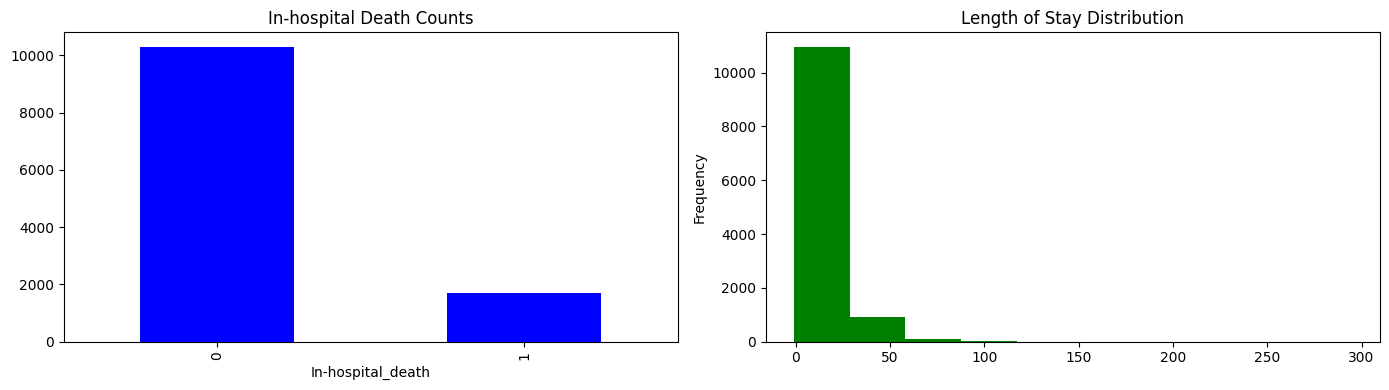

In [6]:
import matplotlib.pyplot as plt

# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
knn_df['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
knn_df['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()


### 3-IN_HOSPITAL_DEATH PREDICTION

**3.1 -Create a function that**
 - remove the outcome columns and palaces RecordID as index
 - splits the data
 - normalizes the data
 - creates / compiles and trains a basic model
 - predicts the outcomes


*FUNCTION PARAMETERS*
- Input layer - 64 nodes, activation ReLu, input features

- Hidden layer - 64 nodes activation ReLu

- Output - 1 node, activation sigmoid

*Optimization and cost for the model*
- loss - "mse" # Mean Squared Error

- optimizer - SGD # Stochastic Gradient Descent

- metrics - "mae" # Mean average error  

In order to keep all the results we will save them to finally summarize in a df

In [7]:
# Create a df to save the results
data = {
    "Method": [],
    "mean_precision": [],
    "mean_recall": [],
    "stdev_precision": [],
    "stdev_recall": []
}

df_results = pd.DataFrame(data)


In [8]:
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
11449,161652.0,78.0,1,3,29.549206,1,25.5,21.568627,0.458333,0.9,11.111111,0.4,0.4,0.0,15.0,0.0,128.5775,124.0,151.0,21.774194,2.25,29.0,3.448276,39.2,8.928571,88.0,121.0,5.681818,-0.22086,4.1965,4.6,4.7,2.173913,2.35,27.659574,2.0595,1.9,2.2,5.263158,77.73125,98.75,7.435564,79.5225,0.046619,137.0,0.0,-6.338418e-16,77.0,107.0,7.792208,82.0,0.308106,44.0,46.0,4.545455,2.0,112.0375,217.0,275.0,26.728111,-58.0,7.435,0.067249,323.5,14.683153,-3.958333,36.2,37.7,1.519337,35.8,80.0,180.0,37.5,50.0,-0.650946,28.95,15.37133,0.370833,55.0,0.0,2.320498e-16,3,0


In [9]:
def NN_basic_model(df):
    """
    Builds and trains a basic neural network model for binary classification.

    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.

    Returns:
        float: F1-score on the test set.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
 
    precision = precision_score(y_test, y_pred_binary)
    print(f"precision on test set: {precision:.2f}")
    recall = recall_score(y_test, y_pred_binary)
    print(f"recall on test set: {recall:.2f}")

    return y_test, y_pred_binary

**3.2- Evaluation of the model performance on the two loaded dataframes**

in order to have more information we will run each model 10 times

In [10]:
def run_function_10_times(df, function):
        precision = []
        recall = []
        for i in range(10):   
                y_test, y_pred = function(knn_df)
                prec= precision_score(y_test, y_pred)
                rec = recall_score(y_test, y_pred)
                precision.append(prec)
                recall.append(rec)
        return np.mean(precision), np.mean(recall), np.std(precision), np.std(recall)

In [11]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_basic_model)


Epoch 1/20


300/300 [==============================] - 1s 1ms/step - loss: 0.3597 - accuracy: 0.8566
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3185 - accuracy: 0.8684
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3066 - accuracy: 0.8700
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2970 - accuracy: 0.8750
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2912 - accuracy: 0.8767
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2812 - accuracy: 0.8810
Epoch 7/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2787 - accuracy: 0.8825
Epoch 8/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2746 - accuracy: 0.8831
Epoch 9/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2683 - accuracy: 0.8864
Epoch 10/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2630 - accuracy: 0.8

In [12]:
print(f"basic_NN for Knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "knn_df"
df_results.loc[0] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN for Knn_df : mean_prec = 0.5032204952036399, mean_rec =  0.3483383685800604, stdev_prec = 0.02620385969596124, stdev_recall = 0.03394055108602287


In [13]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_basic_model)

Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 0.3672 - accuracy: 0.8553
Epoch 2/20
300/300 [==============================] - 0s 910us/step - loss: 0.3245 - accuracy: 0.8683
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3067 - accuracy: 0.8704
Epoch 4/20
300/300 [==============================] - 0s 903us/step - loss: 0.3007 - accuracy: 0.8768
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2960 - accuracy: 0.8755
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2890 - accuracy: 0.8766
Epoch 7/20
300/300 [==============================] - 0s 957us/step - loss: 0.2841 - accuracy: 0.8780
Epoch 8/20
300/300 [==============================] - 0s 950us/step - loss: 0.2758 - accuracy: 0.8821
Epoch 9/20
300/300 [==============================] - 0s 934us/step - loss: 0.2751 - accuracy: 0.8855
Epoch 10/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2695 - accura

In [14]:
print(f"basic_NN for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "m1_df"
df_results.loc[1] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN for m1_df : mean_prec = 0.5174880578799044, mean_rec =  0.343202416918429, stdev_prec = 0.020070047398411527, stdev_recall = 0.04769588126130727


**3.3 -Use PCA in the models to check for improvement.**

As PCA already requieres standarization of numerica features a new function must be created but the model will be the same. 

In [15]:
def NN_PCA_model(df):
    """
    Builds and trains an improved neural network model for binary classification using PCA.

    Args:
        Data frame.

    Returns:
        Predicted value and real test value.
    """
        # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    #exclude categorical features from PCA transformation
    categorical_features = ['Gender', 'ICUType', 'MechVent']
    X_train, X_test, pca, explained_variance_ratio = perform_pca(train_data = X_train, test_data = X_test, n_components=0.95, categorical_features=categorical_features)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return y_test, y_pred_binary



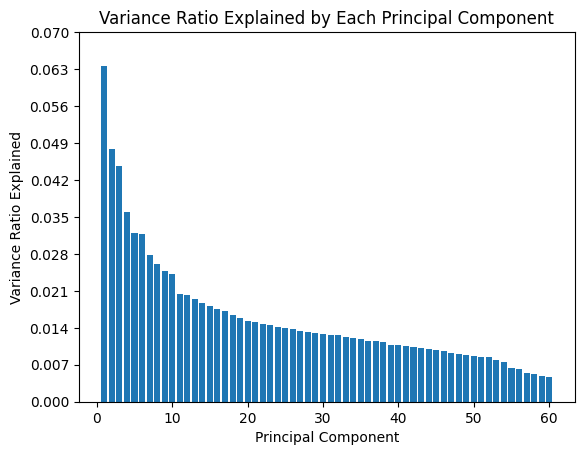

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 956us/step - loss: 0.3638 - accuracy: 0.8516
Epoch 2/20
300/300 [==============================] - 0s 903us/step - loss: 0.3216 - accuracy: 0.8667
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3052 - accuracy: 0.8728
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3007 - accuracy: 0.8710
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2980 - accuracy: 0.8742
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2913 - accuracy: 0.8766
Epoch 7/20
300/300 [==============================] - 0s 991us/step - loss: 0.2844 - accuracy: 0.8827
Epoch 8/20
300/300 [==============================] - 0s 997us/step - loss: 0.2792 - accuracy: 0.8817
Epoch 9/20
300/300 [==============================] - 0s 984us/step - loss: 0.2752 - accuracy: 0.8826
Epoch 10/20
300/300 [

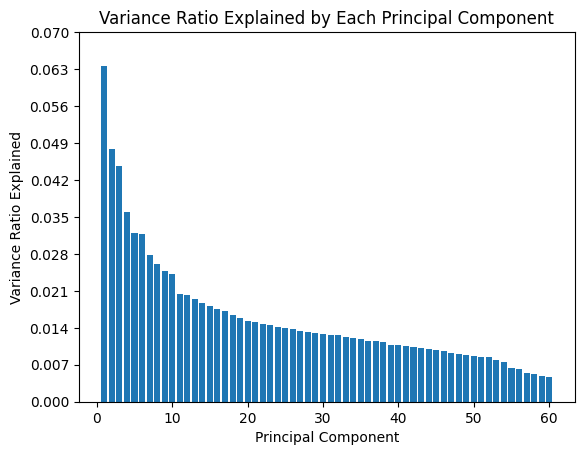

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 0.3666 - accuracy: 0.8577
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3279 - accuracy: 0.8651
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3134 - accuracy: 0.8714
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3038 - accuracy: 0.8744
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2973 - accuracy: 0.8752
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2955 - accuracy: 0.8768
Epoch 7/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2869 - accuracy: 0.8792
Epoch 8/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2861 - accuracy: 0.8801
Epoch 9/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2775 - accuracy: 0.8832
Epoch 10/20
300/300 [==========

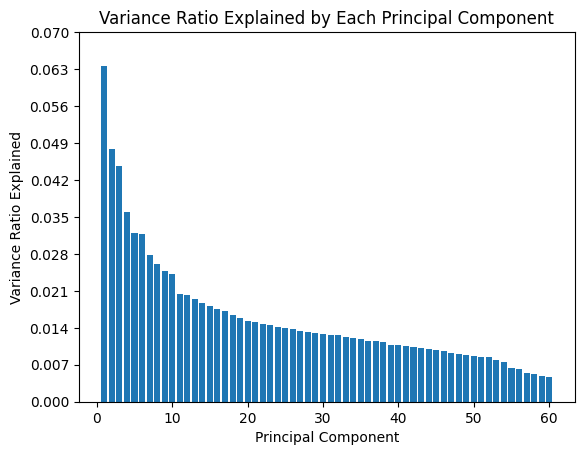

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 0.3624 - accuracy: 0.8581
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3273 - accuracy: 0.8633
Epoch 3/20
300/300 [==============================] - 0s 959us/step - loss: 0.3104 - accuracy: 0.8715
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3001 - accuracy: 0.8740
Epoch 5/20
300/300 [==============================] - 0s 971us/step - loss: 0.3011 - accuracy: 0.8718
Epoch 6/20
300/300 [==============================] - 0s 890us/step - loss: 0.2899 - accuracy: 0.8783
Epoch 7/20
300/300 [==============================] - 0s 873us/step - loss: 0.2877 - accuracy: 0.8799
Epoch 8/20
300/300 [==============================] - 0s 886us/step - loss: 0.2791 - accuracy: 0.8850
Epoch 9/20
300/300 [==============================] - 0s 880us/step - loss: 0.2800 - accuracy: 0.8813
Epoch 10/20
300/300

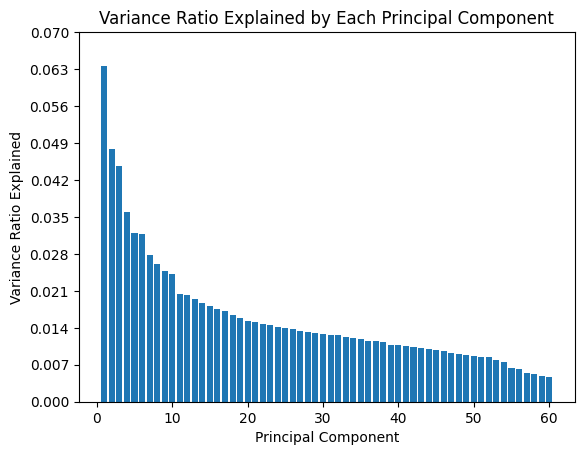

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 979us/step - loss: 0.3598 - accuracy: 0.8566
Epoch 2/20
300/300 [==============================] - 0s 936us/step - loss: 0.3185 - accuracy: 0.8693
Epoch 3/20
300/300 [==============================] - 0s 943us/step - loss: 0.3086 - accuracy: 0.8696
Epoch 4/20
300/300 [==============================] - 0s 926us/step - loss: 0.3024 - accuracy: 0.8743
Epoch 5/20
300/300 [==============================] - 0s 883us/step - loss: 0.2930 - accuracy: 0.8760
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2913 - accuracy: 0.8760
Epoch 7/20
300/300 [==============================] - 0s 880us/step - loss: 0.2850 - accuracy: 0.8778
Epoch 8/20
300/300 [==============================] - 0s 876us/step - loss: 0.2771 - accuracy: 0.8824
Epoch 9/20
300/300 [==============================] - 0s 885us/step - loss: 0.2776 - accuracy: 0.8830
Epoch 10/20
300

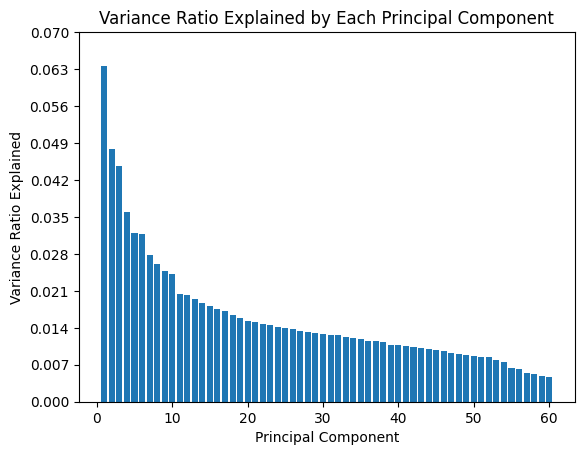

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 946us/step - loss: 0.3691 - accuracy: 0.8534
Epoch 2/20
300/300 [==============================] - 0s 920us/step - loss: 0.3227 - accuracy: 0.8656
Epoch 3/20
300/300 [==============================] - 0s 895us/step - loss: 0.3070 - accuracy: 0.8719
Epoch 4/20
300/300 [==============================] - 0s 901us/step - loss: 0.3018 - accuracy: 0.8750
Epoch 5/20
300/300 [==============================] - 0s 913us/step - loss: 0.2952 - accuracy: 0.8767
Epoch 6/20
300/300 [==============================] - 0s 900us/step - loss: 0.2900 - accuracy: 0.8774
Epoch 7/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2809 - accuracy: 0.8829
Epoch 8/20
300/300 [==============================] - 0s 901us/step - loss: 0.2769 - accuracy: 0.8830
Epoch 9/20
300/300 [==============================] - 0s 893us/step - loss: 0.2768 - accuracy: 0.8854
Epoch 10/20
300

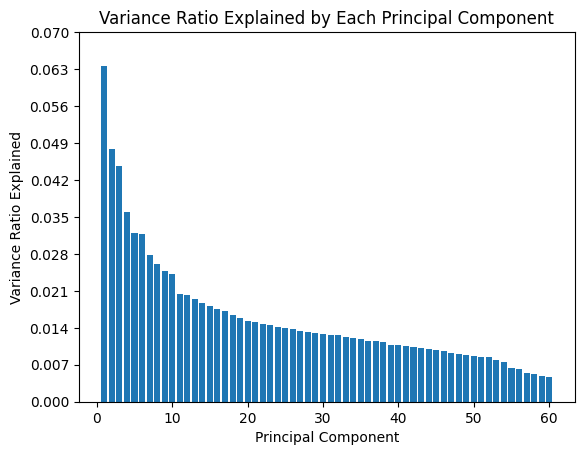

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 952us/step - loss: 0.3654 - accuracy: 0.8572
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3249 - accuracy: 0.8662
Epoch 3/20
300/300 [==============================] - 0s 921us/step - loss: 0.3126 - accuracy: 0.8745
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3061 - accuracy: 0.8727
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2996 - accuracy: 0.8751
Epoch 6/20
300/300 [==============================] - 0s 963us/step - loss: 0.2944 - accuracy: 0.8756
Epoch 7/20
300/300 [==============================] - 0s 944us/step - loss: 0.2861 - accuracy: 0.8811
Epoch 8/20
300/300 [==============================] - 0s 990us/step - loss: 0.2800 - accuracy: 0.8838
Epoch 9/20
300/300 [==============================] - 0s 896us/step - loss: 0.2727 - accuracy: 0.8859
Epoch 10/20
300/300

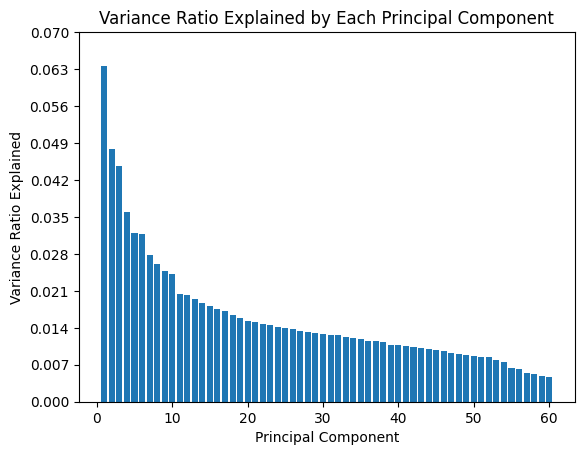

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 977us/step - loss: 0.3654 - accuracy: 0.8535
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3208 - accuracy: 0.8659
Epoch 3/20
300/300 [==============================] - 0s 903us/step - loss: 0.3095 - accuracy: 0.8700
Epoch 4/20
300/300 [==============================] - 0s 885us/step - loss: 0.3003 - accuracy: 0.8756
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2966 - accuracy: 0.8749
Epoch 6/20
300/300 [==============================] - 0s 903us/step - loss: 0.2898 - accuracy: 0.8791
Epoch 7/20
300/300 [==============================] - 0s 943us/step - loss: 0.2847 - accuracy: 0.8783
Epoch 8/20
300/300 [==============================] - 0s 910us/step - loss: 0.2792 - accuracy: 0.8852
Epoch 9/20
300/300 [==============================] - 0s 955us/step - loss: 0.2730 - accuracy: 0.8804
Epoch 10/20
300/3

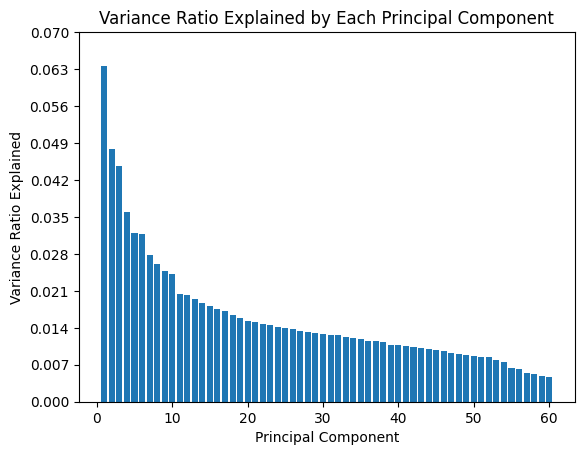

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 951us/step - loss: 0.3657 - accuracy: 0.8510
Epoch 2/20
300/300 [==============================] - 0s 876us/step - loss: 0.3216 - accuracy: 0.8636
Epoch 3/20
300/300 [==============================] - 0s 883us/step - loss: 0.3121 - accuracy: 0.8673
Epoch 4/20
300/300 [==============================] - 0s 887us/step - loss: 0.3043 - accuracy: 0.8705
Epoch 5/20
300/300 [==============================] - 0s 890us/step - loss: 0.2977 - accuracy: 0.8716
Epoch 6/20
300/300 [==============================] - 0s 884us/step - loss: 0.2950 - accuracy: 0.8750
Epoch 7/20
300/300 [==============================] - 0s 886us/step - loss: 0.2894 - accuracy: 0.8767
Epoch 8/20
300/300 [==============================] - 0s 873us/step - loss: 0.2828 - accuracy: 0.8792
Epoch 9/20
300/300 [==============================] - 0s 873us/step - loss: 0.2788 - accuracy: 0.8795
Epoch 10/20
3

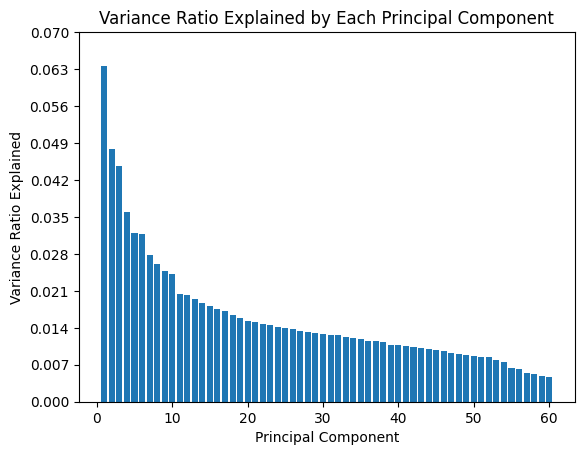

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 987us/step - loss: 0.3610 - accuracy: 0.8544
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3228 - accuracy: 0.8651
Epoch 3/20
300/300 [==============================] - 0s 946us/step - loss: 0.3088 - accuracy: 0.8715
Epoch 4/20
300/300 [==============================] - 0s 893us/step - loss: 0.3047 - accuracy: 0.8717
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2974 - accuracy: 0.8745
Epoch 6/20
300/300 [==============================] - 0s 907us/step - loss: 0.2862 - accuracy: 0.8811
Epoch 7/20
300/300 [==============================] - 0s 896us/step - loss: 0.2804 - accuracy: 0.8791
Epoch 8/20
300/300 [==============================] - 0s 910us/step - loss: 0.2785 - accuracy: 0.8816
Epoch 9/20
300/300 [==============================] - 0s 900us/step - loss: 0.2774 - accuracy: 0.8799
Epoch 10/20
300/3

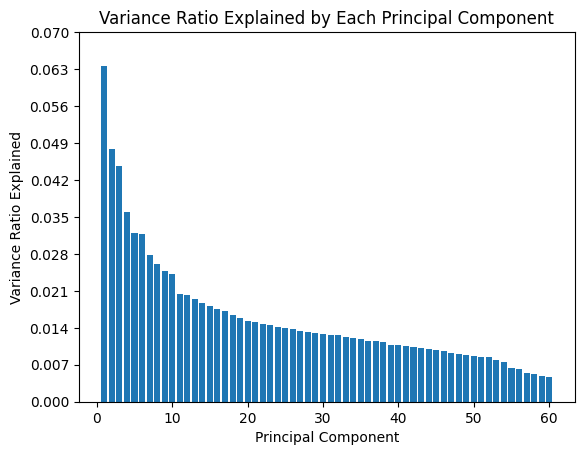

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 959us/step - loss: 0.3689 - accuracy: 0.8570
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3231 - accuracy: 0.8671
Epoch 3/20
300/300 [==============================] - 0s 985us/step - loss: 0.3118 - accuracy: 0.8708
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3036 - accuracy: 0.8729
Epoch 5/20
300/300 [==============================] - 0s 923us/step - loss: 0.2988 - accuracy: 0.8732
Epoch 6/20
300/300 [==============================] - 0s 890us/step - loss: 0.2938 - accuracy: 0.8778
Epoch 7/20
300/300 [==============================] - 0s 891us/step - loss: 0.2890 - accuracy: 0.8776
Epoch 8/20
300/300 [==============================] - 0s 967us/step - loss: 0.2792 - accuracy: 0.8824
Epoch 9/20
300/300 [==============================] - 0s 937us/step - loss: 0.2812 - accuracy: 0.8795
Epoch 10/20
300/3

In [16]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_PCA_model)

In [17]:
print(f"basic_NN_PCA for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "PCA_knn_df"
df_results.loc[2] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_PCA for knn_df : mean_prec = 0.5070017387280596, mean_rec =  0.35891238670694864, stdev_prec = 0.02452217571332788, stdev_recall = 0.048841789433138896


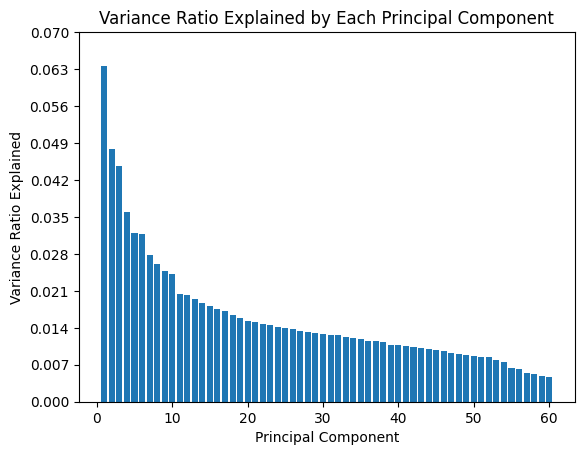

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 0.3744 - accuracy: 0.8539
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3273 - accuracy: 0.8659
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3097 - accuracy: 0.8721
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3053 - accuracy: 0.8736
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2925 - accuracy: 0.8792
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2889 - accuracy: 0.8786
Epoch 7/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2863 - accuracy: 0.8805
Epoch 8/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2800 - accuracy: 0.8839
Epoch 9/20
300/300 [==============================] - 0s 987us/step - loss: 0.2745 - accuracy: 0.8848
Epoch 10/20
300/300 [========

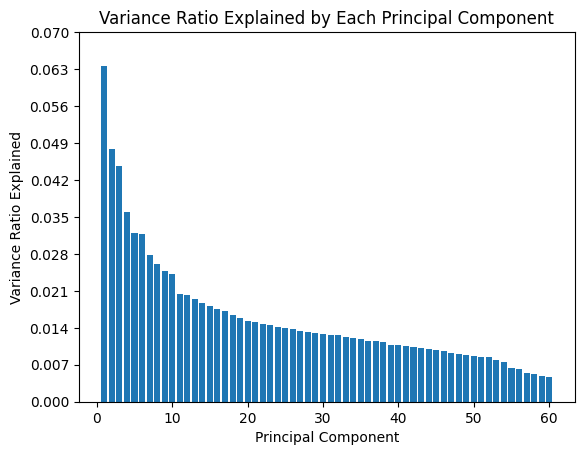

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 999us/step - loss: 0.3589 - accuracy: 0.8568
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3191 - accuracy: 0.8639
Epoch 3/20
300/300 [==============================] - 0s 926us/step - loss: 0.3122 - accuracy: 0.8671
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3023 - accuracy: 0.8711
Epoch 5/20
300/300 [==============================] - 0s 994us/step - loss: 0.2929 - accuracy: 0.8770
Epoch 6/20
300/300 [==============================] - 0s 969us/step - loss: 0.2869 - accuracy: 0.8760
Epoch 7/20
300/300 [==============================] - 0s 979us/step - loss: 0.2856 - accuracy: 0.8770
Epoch 8/20
300/300 [==============================] - 0s 950us/step - loss: 0.2841 - accuracy: 0.8808
Epoch 9/20
300/300 [==============================] - 0s 920us/step - loss: 0.2741 - accuracy: 0.8843
Epoch 10/20
300/3

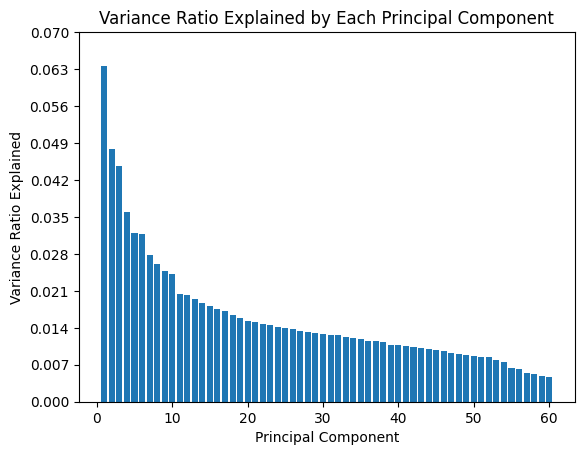

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 0.3618 - accuracy: 0.8537
Epoch 2/20
300/300 [==============================] - 0s 940us/step - loss: 0.3220 - accuracy: 0.8673
Epoch 3/20
300/300 [==============================] - 0s 933us/step - loss: 0.3093 - accuracy: 0.8724
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3016 - accuracy: 0.8715
Epoch 5/20
300/300 [==============================] - 0s 942us/step - loss: 0.2908 - accuracy: 0.8776
Epoch 6/20
300/300 [==============================] - 0s 961us/step - loss: 0.2854 - accuracy: 0.8779
Epoch 7/20
300/300 [==============================] - 0s 923us/step - loss: 0.2775 - accuracy: 0.8806
Epoch 8/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2781 - accuracy: 0.8807
Epoch 9/20
300/300 [==============================] - 0s 990us/step - loss: 0.2687 - accuracy: 0.8884
Epoch 10/20
300/300

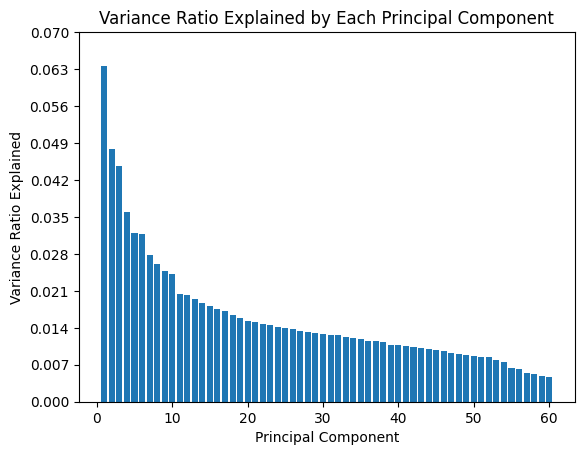

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 0.3682 - accuracy: 0.8504
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3227 - accuracy: 0.8672
Epoch 3/20
300/300 [==============================] - 0s 923us/step - loss: 0.3105 - accuracy: 0.8750
Epoch 4/20
300/300 [==============================] - 0s 931us/step - loss: 0.3026 - accuracy: 0.8728
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2983 - accuracy: 0.8744
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2928 - accuracy: 0.8751
Epoch 7/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2847 - accuracy: 0.8792
Epoch 8/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2802 - accuracy: 0.8836
Epoch 9/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2801 - accuracy: 0.8805
Epoch 10/20
300/300 [======

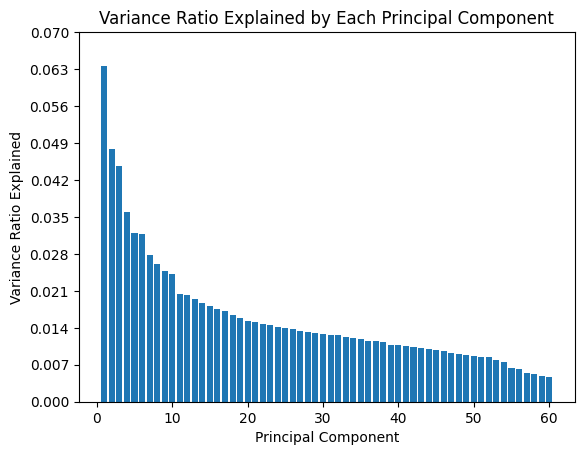

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 987us/step - loss: 0.3603 - accuracy: 0.8519
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.3187 - accuracy: 0.8678
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3069 - accuracy: 0.8710
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2992 - accuracy: 0.8742
Epoch 5/20
300/300 [==============================] - 0s 913us/step - loss: 0.2938 - accuracy: 0.8747
Epoch 6/20
300/300 [==============================] - 0s 950us/step - loss: 0.2882 - accuracy: 0.8760
Epoch 7/20
300/300 [==============================] - 0s 936us/step - loss: 0.2852 - accuracy: 0.8749
Epoch 8/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2805 - accuracy: 0.8783
Epoch 9/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2733 - accuracy: 0.8842
Epoch 10/20
300/300 [==

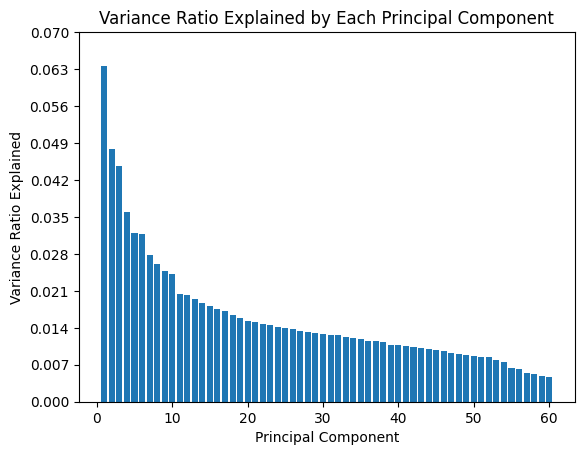

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 974us/step - loss: 0.3645 - accuracy: 0.8556
Epoch 2/20
300/300 [==============================] - 0s 903us/step - loss: 0.3226 - accuracy: 0.8660
Epoch 3/20
300/300 [==============================] - 0s 900us/step - loss: 0.3086 - accuracy: 0.8725
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3020 - accuracy: 0.8717
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2939 - accuracy: 0.8751
Epoch 6/20
300/300 [==============================] - 0s 961us/step - loss: 0.2905 - accuracy: 0.8763
Epoch 7/20
300/300 [==============================] - 0s 980us/step - loss: 0.2874 - accuracy: 0.8763
Epoch 8/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2801 - accuracy: 0.8845
Epoch 9/20
300/300 [==============================] - 0s 916us/step - loss: 0.2769 - accuracy: 0.8813
Epoch 10/20
300/300

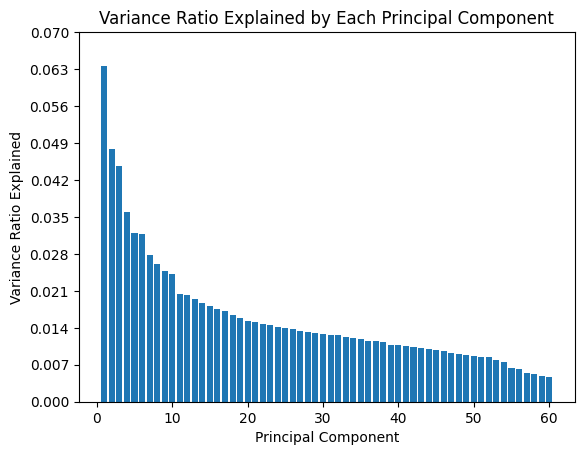

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 0.3781 - accuracy: 0.8531
Epoch 2/20
300/300 [==============================] - 0s 987us/step - loss: 0.3252 - accuracy: 0.8653
Epoch 3/20
300/300 [==============================] - 0s 949us/step - loss: 0.3143 - accuracy: 0.8673
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3058 - accuracy: 0.8722
Epoch 5/20
300/300 [==============================] - 0s 941us/step - loss: 0.2978 - accuracy: 0.8734
Epoch 6/20
300/300 [==============================] - 0s 912us/step - loss: 0.2927 - accuracy: 0.8765
Epoch 7/20
300/300 [==============================] - 0s 928us/step - loss: 0.2899 - accuracy: 0.8823
Epoch 8/20
300/300 [==============================] - 0s 938us/step - loss: 0.2806 - accuracy: 0.8823
Epoch 9/20
300/300 [==============================] - 0s 918us/step - loss: 0.2784 - accuracy: 0.8801
Epoch 10/20
300/3

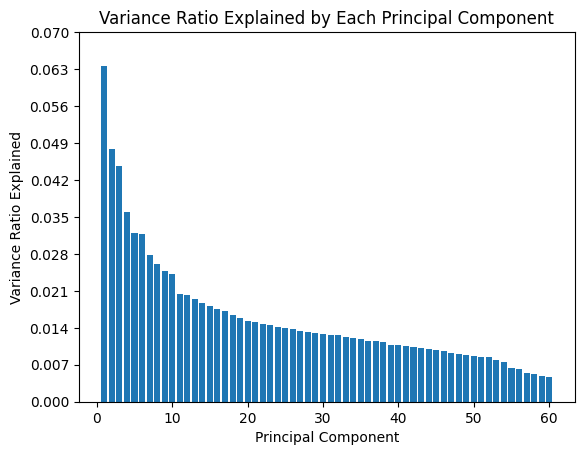

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 1ms/step - loss: 0.3664 - accuracy: 0.8578
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3233 - accuracy: 0.8674
Epoch 3/20
300/300 [==============================] - 0s 963us/step - loss: 0.3116 - accuracy: 0.8683
Epoch 4/20
300/300 [==============================] - 0s 929us/step - loss: 0.3073 - accuracy: 0.8703
Epoch 5/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2963 - accuracy: 0.8755
Epoch 6/20
300/300 [==============================] - 0s 924us/step - loss: 0.2873 - accuracy: 0.8781
Epoch 7/20
300/300 [==============================] - 0s 933us/step - loss: 0.2875 - accuracy: 0.8786
Epoch 8/20
300/300 [==============================] - 0s 916us/step - loss: 0.2834 - accuracy: 0.8802
Epoch 9/20
300/300 [==============================] - 0s 993us/step - loss: 0.2772 - accuracy: 0.8834
Epoch 10/20
300/300

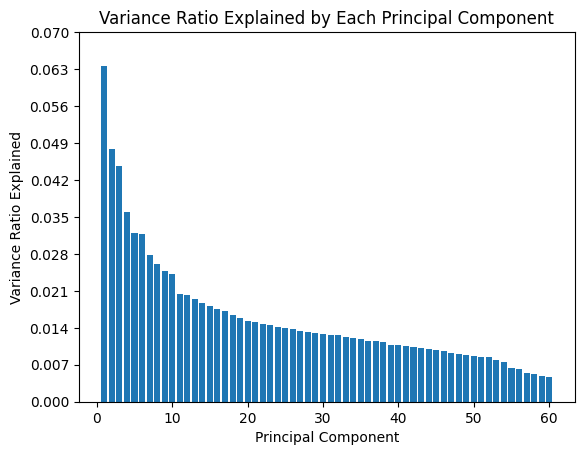

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 946us/step - loss: 0.3570 - accuracy: 0.8584
Epoch 2/20
300/300 [==============================] - 0s 900us/step - loss: 0.3195 - accuracy: 0.8673
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3093 - accuracy: 0.8735
Epoch 4/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3017 - accuracy: 0.8718
Epoch 5/20
300/300 [==============================] - 0s 919us/step - loss: 0.2931 - accuracy: 0.8744
Epoch 6/20
300/300 [==============================] - 0s 900us/step - loss: 0.2846 - accuracy: 0.8773
Epoch 7/20
300/300 [==============================] - 0s 900us/step - loss: 0.2875 - accuracy: 0.8793
Epoch 8/20
300/300 [==============================] - 0s 919us/step - loss: 0.2790 - accuracy: 0.8806
Epoch 9/20
300/300 [==============================] - 0s 913us/step - loss: 0.2731 - accuracy: 0.8861
Epoch 10/20
300/3

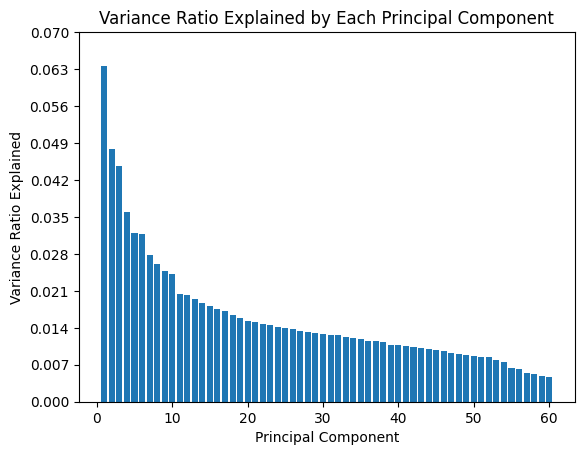

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/20
300/300 [==============================] - 1s 986us/step - loss: 0.3687 - accuracy: 0.8554
Epoch 2/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3237 - accuracy: 0.8670
Epoch 3/20
300/300 [==============================] - 0s 1ms/step - loss: 0.3100 - accuracy: 0.8684
Epoch 4/20
300/300 [==============================] - 0s 934us/step - loss: 0.3037 - accuracy: 0.8712
Epoch 5/20
300/300 [==============================] - 0s 941us/step - loss: 0.2964 - accuracy: 0.8771
Epoch 6/20
300/300 [==============================] - 0s 1ms/step - loss: 0.2921 - accuracy: 0.8757
Epoch 7/20
300/300 [==============================] - 0s 958us/step - loss: 0.2845 - accuracy: 0.8755
Epoch 8/20
300/300 [==============================] - 0s 961us/step - loss: 0.2818 - accuracy: 0.8800
Epoch 9/20
300/300 [==============================] - 0s 926us/step - loss: 0.2738 - accuracy: 0.8821
Epoch 10/20
300/300

In [18]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_PCA_model)

In [19]:
print(f"basic_NN_PCA for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "PCA_m1_df"
df_results.loc[3] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_PCA for m1_df : mean_prec = 0.5304498990750373, mean_rec =  0.3314199395770393, stdev_prec = 0.020441589503288317, stdev_recall = 0.035799010761636434


**3.4 -Managing the inbalance problem.**

Balancing the initial dataframes with two different methods:

 - SOMTE
 - RandomOverSampler

In [20]:
def NN_Balanced_model(df, method):
    """
    Builds and trains an improved neural network model for binary classification with previous balanced strategy of the df.

    Args:
        Data frame.
        Method: balancing method to be applied to the Data frame

    Returns:
        Predicted value and real test value.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data balancing
    met = method(random_state=42)
    X_train, y_train = met.fit_resample(X_train, y_train)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Add dropout layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 20
    batch_size = 32
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return  y_test,y_pred_binary

as now we are using a function (NN_Balanced_model) that requiers an extra argument from run_10_times function we must use a labmda function to be able to pass this extra argument.

In [21]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_model(knn_df, method=SMOTE))

Epoch 1/20
514/514 [==============================] - 1s 951us/step - loss: 0.4847 - accuracy: 0.7662
Epoch 2/20
514/514 [==============================] - 1s 1ms/step - loss: 0.4002 - accuracy: 0.8214
Epoch 3/20
514/514 [==============================] - 0s 944us/step - loss: 0.3617 - accuracy: 0.8425
Epoch 4/20
514/514 [==============================] - 0s 958us/step - loss: 0.3391 - accuracy: 0.8538
Epoch 5/20
514/514 [==============================] - 1s 994us/step - loss: 0.3203 - accuracy: 0.8640
Epoch 6/20
514/514 [==============================] - 1s 975us/step - loss: 0.2999 - accuracy: 0.8766
Epoch 7/20
514/514 [==============================] - 0s 944us/step - loss: 0.2887 - accuracy: 0.8804
Epoch 8/20
514/514 [==============================] - 1s 1ms/step - loss: 0.2751 - accuracy: 0.8877
Epoch 9/20
514/514 [==============================] - 1s 978us/step - loss: 0.2669 - accuracy: 0.8884
Epoch 10/20
514/514 [==============================] - 0s 926us/step - loss: 0.2558 - 

In [22]:
print(f"basic_NN_smote for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "Smote_knn_df"
df_results.loc[4] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_smote for knn_df : mean_prec = 0.3536266452412528, mean_rec =  0.44108761329305135, stdev_prec = 0.013952007315624177, stdev_recall = 0.04386390673808226


In [23]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, method=SMOTE))

Epoch 1/20
514/514 [==============================] - 1s 1ms/step - loss: 0.4881 - accuracy: 0.7669
Epoch 2/20
514/514 [==============================] - 1s 973us/step - loss: 0.4088 - accuracy: 0.8163
Epoch 3/20
514/514 [==============================] - 0s 966us/step - loss: 0.3743 - accuracy: 0.8365
Epoch 4/20
514/514 [==============================] - 0s 963us/step - loss: 0.3581 - accuracy: 0.8460
Epoch 5/20
514/514 [==============================] - 0s 913us/step - loss: 0.3334 - accuracy: 0.8545
Epoch 6/20
514/514 [==============================] - 0s 879us/step - loss: 0.3235 - accuracy: 0.8601
Epoch 7/20
514/514 [==============================] - 0s 935us/step - loss: 0.3090 - accuracy: 0.8656
Epoch 8/20
514/514 [==============================] - 1s 1ms/step - loss: 0.3004 - accuracy: 0.8709
Epoch 9/20
514/514 [==============================] - 0s 912us/step - loss: 0.2896 - accuracy: 0.8785
Epoch 10/20
514/514 [==============================] - 0s 910us/step - loss: 0.2782 - 

In [24]:
print(f"basic_NN_smote for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "Smote_m1_df"
df_results.loc[5] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_smote for m1_df : mean_prec = 0.3555092200149654, mean_rec =  0.4290030211480363, stdev_prec = 0.00981929432974472, stdev_recall = 0.030928057745183635


In [25]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_model(knn_df, method=RandomOverSampler))

Epoch 1/20
514/514 [==============================] - 1s 1ms/step - loss: 0.5263 - accuracy: 0.7405
Epoch 2/20
514/514 [==============================] - 1s 1ms/step - loss: 0.4501 - accuracy: 0.7926
Epoch 3/20
514/514 [==============================] - 0s 944us/step - loss: 0.4165 - accuracy: 0.8095
Epoch 4/20
514/514 [==============================] - 0s 911us/step - loss: 0.3904 - accuracy: 0.8274
Epoch 5/20
514/514 [==============================] - 0s 905us/step - loss: 0.3648 - accuracy: 0.8434
Epoch 6/20
514/514 [==============================] - 0s 912us/step - loss: 0.3423 - accuracy: 0.8543
Epoch 7/20
514/514 [==============================] - 1s 996us/step - loss: 0.3330 - accuracy: 0.8595
Epoch 8/20
514/514 [==============================] - 1s 1ms/step - loss: 0.3116 - accuracy: 0.8657
Epoch 9/20
514/514 [==============================] - 1s 1ms/step - loss: 0.3027 - accuracy: 0.8718
Epoch 10/20
514/514 [==============================] - 1s 1ms/step - loss: 0.2953 - accura

In [26]:
print(f"basic_NN_ros for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "ros_knn_df"
df_results.loc[6] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_ros for knn_df : mean_prec = 0.382222103732345, mean_rec =  0.5253776435045318, stdev_prec = 0.01805499924155648, stdev_recall = 0.045567285886958894


In [27]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_model(m1_df, method=RandomOverSampler))

Epoch 1/20
514/514 [==============================] - 1s 994us/step - loss: 0.5381 - accuracy: 0.7310
Epoch 2/20
514/514 [==============================] - 1s 993us/step - loss: 0.4699 - accuracy: 0.7806
Epoch 3/20
514/514 [==============================] - 1s 1ms/step - loss: 0.4375 - accuracy: 0.7963
Epoch 4/20
514/514 [==============================] - 1s 1ms/step - loss: 0.4085 - accuracy: 0.8116
Epoch 5/20
514/514 [==============================] - 0s 954us/step - loss: 0.3864 - accuracy: 0.8245
Epoch 6/20
514/514 [==============================] - 1s 998us/step - loss: 0.3694 - accuracy: 0.8345
Epoch 7/20
514/514 [==============================] - 1s 1ms/step - loss: 0.3576 - accuracy: 0.8433
Epoch 8/20
514/514 [==============================] - 1s 1ms/step - loss: 0.3414 - accuracy: 0.8513
Epoch 9/20
514/514 [==============================] - 1s 1ms/step - loss: 0.3320 - accuracy: 0.8582
Epoch 10/20
514/514 [==============================] - 1s 1ms/step - loss: 0.3135 - accuracy

In [28]:
print(f"basic_NN_ros for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
method_name = "ros_m1_df"
df_results.loc[7] = [method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]

basic_NN_ros for m1_df : mean_prec = 0.3870570171774158, mean_rec =  0.5211480362537764, stdev_prec = 0.020094409907578818, stdev_recall = 0.049018068699661486


In [30]:
df_results_12000= df_results
df_results_12000['Model'] = 'NN'
df_results_1200 = df_results_12000[['Model'] + [col for col in df_results_12000.columns if col != 'Model']]

In [31]:
df_results_12000

,Method,mean_precision,mean_recall,stdev_precision,stdev_recall,Model
0,knn_df,0.503220,0.348338,0.026204,0.033941,NN
1,m1_df,0.517488,0.343202,0.020070,0.047696,NN
2,PCA_knn_df,0.507002,0.358912,0.024522,0.048842,NN
3,PCA_m1_df,0.530450,0.331420,0.020442,0.035799,NN
4,Smote_knn_df,0.353627,0.441088,0.013952,0.043864,NN
5,Smote_m1_df,0.355509,0.429003,0.009819,0.030928,NN
6,ros_knn_df,0.382222,0.525378,0.018055,0.045567,NN
7,ros_m1_df,0.387057,0.521148,0.020094,0.049018,NN
